In [1]:
import mlflow
from dotenv import load_dotenv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns
import joblib
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

import xgboost as xgb
from xgboost import XGBRegressor
import optuna
from sklearn.model_selection import GroupKFold, cross_validate
from sklearn.metrics import mean_squared_error
import os
import platform

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression 
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

# **Introduction**

It Help in the machine learning workflow. As a Python package, it can be easily installed using `pip install mlflow`. MLflow is composed of four main modules:

- **Tracking**:  allows you to log and query experiments, including code versions, parameters, metrics, and output files, ensuring you can reproduce and compare results across different runs.

- **Projects**: provides a standard format for packaging reusable data science code. It enables you to organize your code in a way that makes it easy to run and reproduce across different environments.

- **Models**: MLflow Models offers a unified approach for packaging machine learning models. It supports multiple formats (e.g., TensorFlow, PyTorch, Scikit-Learn) 

- **Registry**: The Model Registry provides a centralized place to manage and govern the full lifecycle of your models. It includes functionalities for versioning, staging, and annotating models, helping maintain an organized workflow from experimentation to production.


**Tracking experiments**

MLflow traking module allows to organize the experiments into runs, and keep track of the :

- **Parameters**:  path to train dataset, number of epochs, learning rate, etc.

- **metrics**: accuracy, loss, etc.

- **metadata**: code version, git commit, etc.

- **artifcats**: any file produced during the run, such as model, plots, etc.

- **models**: the model itself, which can be saved and loaded using the MLflow API.

Creating a new experiment by using `.set_experiment()` method: 



In [2]:
# Load .env 
load_dotenv()

# Determine the operating system
is_linux = platform.system() == 'Linux'
is_windows = platform.system() == 'Windows'

if is_linux:
    root_url = os.path.expanduser(os.getenv("ROOT_URL_LINUX"))
elif is_windows:
    root_url = os.getenv("ROOT_URL_WINDOWS")
else:
    raise EnvironmentError("Unsupported operating system")

# Construct paths for MLflow tracking
mlflow_tracking_uri = str(Path(root_url) / 'mlops-zoomcamp/01-mlflow-tracking/mlruns')

os.environ["MLFLOW_TRACKING_URI"] = mlflow_tracking_uri
experiment_name = os.getenv("MLFLOW_EXPERIMENT_NAME")

print(f"MLFLOW_EXPERIMENT_NAME set to: {experiment_name}")
print(f"MLFLOW_TRACKING_URI set to: {mlflow_tracking_uri}")

mlflow.set_tracking_uri(mlflow_tracking_uri)
mlflow.set_experiment(experiment_name)


2024/09/22 14:03:14 INFO mlflow.tracking.fluent: Experiment with name 'taxi-trip' does not exist. Creating a new experiment.


MLFLOW_EXPERIMENT_NAME set to: taxi-trip
MLFLOW_TRACKING_URI set to: /home/marcos/GitHub/mlops-zoomcamp/01-mlflow-tracking/mlruns


<Experiment: artifact_location='/home/marcos/GitHub/mlops-zoomcamp/01-mlflow-tracking/mlruns/474405561834174778', creation_time=1727024594420, experiment_id='474405561834174778', last_update_time=1727024594420, lifecycle_stage='active', name='taxi-trip', tags={}>

## Preprocessing Taxi Data

In [3]:
def preprocess_trip_data(file_path, min_duration=200, max_duration=3600):

    df = pd.read_parquet(file_path)

    df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)

    # Minutes in  a day : 0-1440
    df['min_of_day'] = (60*df['lpep_pickup_datetime'].dt.hour + df['lpep_pickup_datetime'].dt.minute)
    # Days in a week: 0-6, where 0 is Monday and 6 Sunday
    df['day_of_week'] = df['lpep_pickup_datetime'].dt.dayofweek
    # Days in a year: 1-365 (or 366)
    df['day_of_year'] = df['lpep_pickup_datetime'].dt.dayofyear
    # Time of the  trip
    df['trip_duration'] = (df['lpep_dropoff_datetime']- df['lpep_pickup_datetime']).dt.seconds
    
    # subset the data between min_duration and max_duration
    df = df[(df['trip_duration'] >= min_duration) & (df['trip_duration'] <= max_duration)].copy()
    df = df[df['trip_distance'] > 0.0].dropna(subset=['trip_distance'])
    
    
    df['trip_duration'] = np.log1p(df['trip_duration'])
    
    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    df['PU_DO']  = df['PULocationID'] + '_' + df['DOLocationID']
    columns = ['PU_DO', 'min_of_day', 'day_of_week', 'day_of_year', 'trip_distance', 'trip_duration']

    return df[columns].copy()


df_train = preprocess_trip_data('data/raw/green/2023/01/green_tripdata_2023_01.parquet')
df_val = preprocess_trip_data('data/raw/green/2023/02/green_tripdata_2023_02.parquet')

X_train = df_train.drop(columns=['trip_duration'])
y_train = df_train['trip_duration']

X_val = df_val.drop(columns=['trip_duration'])
y_val = df_val['trip_duration']

## Trining and Saving Model Pipeline

In [4]:
categorical_features = ['PU_DO']
numerical_features = ['min_of_day', 'day_of_week', 'day_of_year','trip_distance']

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('num', StandardScaler(), numerical_features)
    ])

pipeline = Pipeline([
    ('preprocessor', preprocessor),  
    ('regressor', LinearRegression())  
])

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_val)

rmse = mean_squared_error(y_val, y_pred, squared=False)
print(f"RMSE: {rmse}")

RMSE: 0.36220934023321083


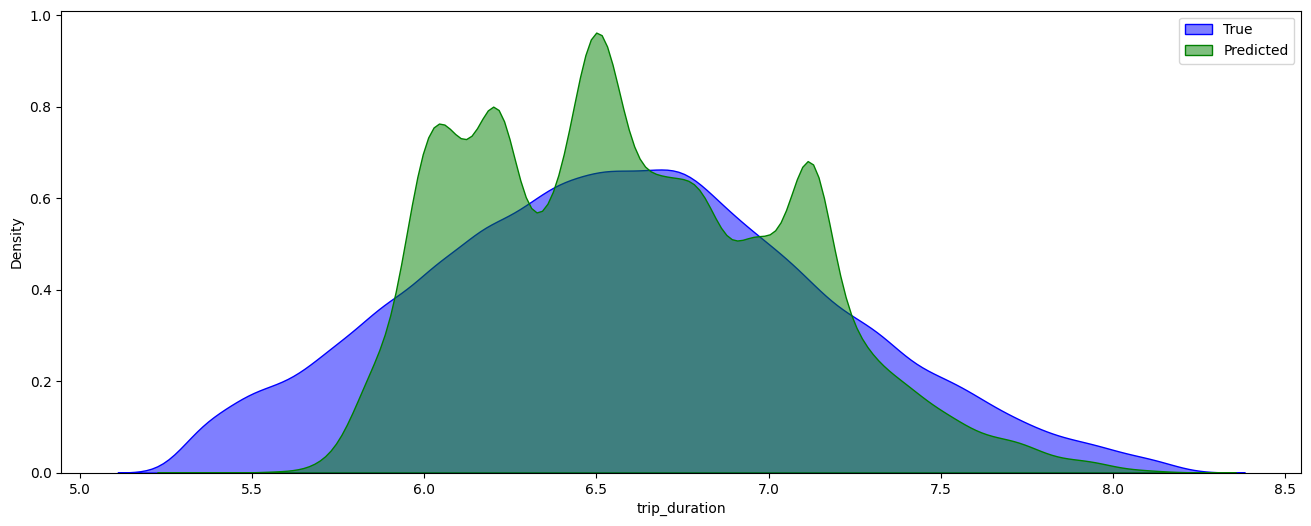

In [5]:
plt.figure(figsize=(16, 6))

# KDE plot for residuals
sns.kdeplot(y_val, color='blue', fill=True, alpha=0.5, label='True')
sns.kdeplot(y_pred, color='green', fill=True, alpha=0.5, label='Predicted')
plt.legend()


In [6]:
# Create directory to save the model
os.makedirs('models', exist_ok=True)

# Define the filename for the saved model
model_filename = 'models/pipeline_lr_model.joblib'

# Save the pipeline (including preprocessing and model)
joblib.dump(pipeline, model_filename)

print(f"Model saved to: {model_filename}")

Model saved to: models/pipeline_lr_model.joblib


# MLflow Structure

**Experiment:** An experiment is a container for multiple runs. It has a unique experiment ID that groups together all the runs related to a specific experiment or goal. We can think of an experiment as a folder that holds many runs. Each experiment can be used to track a different set of experiments, such as hyperparameter tuning or model comparison.

**Run:** A run represents a single execution or trial within an experiment. Each run has a unique run ID, and it logs parameters, metrics, artifacts, and other information associated with that specific run.
A run is essentially a child of an experiment, and multiple runs can belong to the same experiment. Runs allow you to track different configurations or experiments, like different hyperparameters or models, under the same experiment.

**Parameters:** Parameters are variables that can be logged and associated with a run. They are typically used to track hyperparameters or other input values that influence the outcome of the run. For example, the learning rate or the number of epochs are common parameters that can be logged.


In MLflow, a run is a single instance of an experiment where we train a model, log parameters, metrics, and artifacts. However, to try different configurations or models under the same overall goal or experiment we can use nested runs. Nested runs are runs that are created within another run, allowing us to group related runs together. This can be useful when we want to compare different models or hyperparameters under the same experiment. The folder structure for the nested runs in Mlflow are the following:


```
Experiment (experiment_id: 123)
│
├── Run 1 (run_id: abc123)
│   ├── parameters: alpha=0.01
│   ├── metrics: rmse=0.85
│   ├── artifacts: lasso_model_alpha_0.01.joblib
│   ├── tags
│
├── Run 2 (run_id: def456)
│   ├── parameters: alpha=0.1
│   ├── metrics: rmse=0.78
│   ├── artifacts: lasso_model_alpha_0.1.joblib
│   ├── tags
│
├── Run 3 (run_id: ghi789)
│   ├── parameters: alpha=0.2
│   ├── metrics: rmse=0.81
│   ├── artifacts: lasso_model_alpha_0.2.joblib
│   ├── tags
```
<center><img src="figures/mlflow_folder_structure.png" width="800" height="800"></center>

**Usefull Commands**

1. **Tags** (`.set_tag`):
   - Used to categorize and label runs, making them easier to find and organize in the MLflow UI.

2. **Logging Parameters** (`.log_param`):
   - Tracks hyperparameters like **alpha** and important metadata such as dataset paths, making it possible to recreate or analyze the run's conditions.

3. **Logging Metrics** (`.log_metric`):
   - Tracks the performance of the model, such as **RMSE**, providing a quantifiable metric that can be compared across different runs or experiments.

4. **Logging Artifacts** (`.log_artifact`):
   - Saves important files (like trained models) as artifacts, ensuring that they are available for future use or deployment.

In [7]:
categorical_features = ['PU_DO']
numerical_features = ['min_of_day', 'day_of_week', 'day_of_year', 'trip_distance']

# Define the preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('num', StandardScaler(), numerical_features)
    ])

# Loop over different alpha values
with mlflow.start_run(run_name="Parent Experiment"):
    # Log basic parameters for the experiment
    mlflow.set_tag("experiment_type", "Hyperparameter tuning for Lasso")
    mlflow.log_param("train-data-path", "data/raw/green/2023/01/green_tripdata_2023_01.parquet")
    mlflow.log_param("valid-data-path", "data/raw/green/2023/02/green_tripdata_2023_02.parquet")
    
    for alpha in [0.001, 0.01, 0.1, 0.2, 0.4]:
        # Start a nested run for each alpha value
        run_name = f"Lasso model with alpha={alpha}"
        with mlflow.start_run(nested=True, run_name=run_name):
            mlflow.log_param("alpha", alpha)
            
            # Create the pipeline (preprocessing + model)
            pipeline = Pipeline([
                ('preprocessor', preprocessor),  # Preprocessing step
                ('regressor', Lasso(alpha=alpha))  # Model step with Lasso and alpha value
            ])
            
            # Split your data into train and validation sets
            X_train = df_train.drop(columns=["trip_duration"])
            y_train = df_train["trip_duration"]
            X_val = df_val.drop(columns=["trip_duration"])
            y_val = df_val["trip_duration"]
            
            # Train the model
            pipeline.fit(X_train, y_train)
            
            # Predict on validation set
            y_pred = pipeline.predict(X_val)
            
            # Calculate the RMSE
            rmse = mean_squared_error(y_val, y_pred, squared=False)
            mlflow.log_metric("rmse", rmse)
            
            # Save the trained pipeline model
            os.makedirs('models', exist_ok=True)
            model_filename = f'models/lasso_model_alpha_{alpha}.joblib'
            joblib.dump(pipeline, model_filename)

            print(f"Model saved to: {model_filename}")

            # Log the model as an artifact in MLflow
            mlflow.log_artifact(local_path=model_filename, artifact_path="models")
    
    mlflow.end_run()

Model saved to: models/lasso_model_alpha_0.001.joblib
Model saved to: models/lasso_model_alpha_0.01.joblib
Model saved to: models/lasso_model_alpha_0.1.joblib
Model saved to: models/lasso_model_alpha_0.2.joblib
Model saved to: models/lasso_model_alpha_0.4.joblib




<center><img src="figures/mlflow_experiment_ui.png"></center>

# XGBoost and Bayesian Optimization

In [8]:
class RegressorParameterizer(object):
    """
    Class built to utilize for model training with optuna.
    """

    XGBOOST_NAME = 'xgboost'
    LASSO_NAME = 'lasso'

    def __init__(self, model_name, model_parameters, seed: int = 42):
        self.model_name = model_name
        self.model_parameters = model_parameters
        self.seed = seed

    def select_model(self, **kwargs):
        """
        Select the model based on model_name.
        """
        if self.model_name == self.XGBOOST_NAME:
            return XGBRegressor(random_state=self.seed, **kwargs)
        elif self.model_name == self.LASSO_NAME:
            return Lasso(random_state=self.seed, **kwargs)
        else:
            raise ValueError(f"Unsupported model: {self.model_name}")

    def create_model_parameters(self, trial):
        """
        Create model-specific hyperparameters using an Optuna trial.
        This version handles float and int types with optional step parameters.
        """
        params = {}

        for param_name, param_info in self.model_parameters.items():

            if param_info['type'] == 'float':
                # Check if a step parameter exists
                if 'step' in param_info:
                    params[param_name] = trial.suggest_float(
                        name=param_name,
                        low=param_info['low'],
                        high=param_info['high'],
                        step=param_info['step'],  # Use step if present
                        log=param_info.get('log', False)
                    )
                else:
                    params[param_name] = trial.suggest_float(
                        name=param_name,
                        low=param_info['low'],
                        high=param_info['high'],
                        log=param_info.get('log', False)  # No step, continuous search
                    )

            elif param_info['type'] == 'int':
                params[param_name] = trial.suggest_int(
                    name=param_name,
                    low=param_info['low'],
                    high=param_info['high'],
                    step=param_info.get('step', 1)  # Use step if present, else use 1
                )

            elif param_info['type'] == 'categorical':
                params[param_name] = trial.suggest_categorical(
                    name=param_name,
                    choices=param_info['choices']
                )

        return params

<center><img src="figures/optuna_structure.png" width="800" height="400" ></center>

In [9]:
def objective(trial, X_train, y_train, model_name, model_parameters):
    
    model_parameterizer = RegressorParameterizer(model_name, model_parameters)
    params = model_parameterizer.create_model_parameters(trial)
    regressor = model_parameterizer.select_model(**params)
    
    
    ### Pipeline
    categorical_features = ['PU_DO']
    numerical_features = ['min_of_day', 'day_of_week', 'day_of_year','trip_distance']   
    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
            ('num', StandardScaler(), numerical_features)
        ])
    
    
    pipeline = Pipeline([
        ('preprocessor', preprocessor), 
        ('regressor', regressor) 
    ])
    ###

    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    scoring = {
        'rmse': 'neg_root_mean_squared_error', 
        'r2': 'r2',                           
        'mae': 'neg_mean_absolute_error'      
    }
    
    cv_results = cross_validate(
        pipeline, 
        X_train, 
        y_train, 
        cv=kf, 
        scoring=scoring,  
        return_train_score=True,  
        n_jobs=-1
    )
    
    mean_rmse = -np.mean(cv_results['test_rmse']) 
    
    mean_train_rmse = -np.mean(cv_results['train_rmse']) 
    mean_test_r2 = np.mean(cv_results['test_r2']) 
    mean_train_r2 = np.mean(cv_results['train_r2']) 
    
    print(f"Mean Test RMSE: {mean_rmse}")
    print(f"Mean Train RMSE: {mean_train_rmse}")
    print(f"Mean Test R²: {mean_test_r2}")
    print(f"Mean Train R²: {mean_train_r2}")
    
    return mean_rmse

<center><img src="figures/optimizer_type.png" width="800" height="400" ></center>

In [10]:
model_parameters_xgboost = {
    'learning_rate': {'type': 'float', 'low': 0.01, 'high': 0.2, 'log': True},
    'max_depth': {'type': 'int', 'low': 3, 'high': 10},
    'n_estimators': {'type': 'int', 'low': 100, 'high': 1000},
    'reg_lambda': {'type': 'float', 'low': 1e-5, 'high': 10, 'step': 0.01}, 
    'reg_alpha': {'type': 'float', 'low': 1e-5, 'high': 10, 'step': 0.01},  
    'subsample': {'type': 'float', 'low': 0.5, 'high': 1.0}  
}


X_train = df_train.drop(columns=['trip_duration'])
y_train = df_train['trip_duration']


study = optuna.create_study(direction='minimize')
study.optimize(lambda trial: objective(trial, X_train, y_train,  'xgboost', model_parameters_xgboost), n_trials=5)

best_params = study.best_params
best_value = study.best_value

print(f"Best parameters: {best_params}")
print(f"Best RMSE: {best_value}")

[I 2024-09-22 14:03:19,676] A new study created in memory with name: no-name-8ceffc02-306f-4189-ade1-011d0c1bc229
/home/marcos/.local/share/virtualenvs/01-mlflow-tracking-T1Yv4_EQ/lib/python3.10/site-packages/optuna/distributions.py:689: UserWarning: The distribution is specified by [1e-05, 10] and step=0.01, but the range is not divisible by `step`. It will be replaced by [1e-05, 9.99001].
  warnings.warn(
[I 2024-09-22 14:04:18,181] Trial 0 finished with value: 0.25980883507009433 and parameters: {'learning_rate': 0.1649528473955612, 'max_depth': 10, 'n_estimators': 953, 'reg_lambda': 4.71001, 'reg_alpha': 1.93001, 'subsample': 0.6736065800678215}. Best is trial 0 with value: 0.25980883507009433.


Mean Test RMSE: 0.25980883507009433
Mean Train RMSE: 0.16619858713225558
Mean Test R²: 0.7927934443564414
Mean Train R²: 0.9152291110634552


[I 2024-09-22 14:04:31,943] Trial 1 finished with value: 0.24392505410874596 and parameters: {'learning_rate': 0.19146255145013838, 'max_depth': 9, 'n_estimators': 709, 'reg_lambda': 7.1700099999999996, 'reg_alpha': 0.10001, 'subsample': 0.8817373579708616}. Best is trial 1 with value: 0.24392505410874596.


Mean Test RMSE: 0.24392505410874596
Mean Train RMSE: 0.1985296517212167
Mean Test R²: 0.8173558645566356
Mean Train R²: 0.8790393355580998


[I 2024-09-22 14:04:33,425] Trial 2 finished with value: 0.26747987616504243 and parameters: {'learning_rate': 0.17605677377248227, 'max_depth': 3, 'n_estimators': 257, 'reg_lambda': 1.19001, 'reg_alpha': 8.43001, 'subsample': 0.9104724777271495}. Best is trial 1 with value: 0.24392505410874596.


Mean Test RMSE: 0.26747987616504243
Mean Train RMSE: 0.26452603421296983
Mean Test R²: 0.7803684078050466
Mean Train R²: 0.7852541523306078


[I 2024-09-22 14:04:34,388] Trial 3 finished with value: 0.27436396631444404 and parameters: {'learning_rate': 0.0926829080858194, 'max_depth': 4, 'n_estimators': 118, 'reg_lambda': 6.40001, 'reg_alpha': 4.94001, 'subsample': 0.5941891243379328}. Best is trial 1 with value: 0.24392505410874596.


Mean Test RMSE: 0.27436396631444404
Mean Train RMSE: 0.27201180835225314
Mean Test R²: 0.7689255773171368
Mean Train R²: 0.7729275646835952


[I 2024-09-22 14:04:47,240] Trial 4 finished with value: 0.261337419423988 and parameters: {'learning_rate': 0.06519808985938291, 'max_depth': 10, 'n_estimators': 425, 'reg_lambda': 8.75001, 'reg_alpha': 6.970009999999999, 'subsample': 0.5558400324876602}. Best is trial 1 with value: 0.24392505410874596.


Mean Test RMSE: 0.261337419423988
Mean Train RMSE: 0.2466349009008991
Mean Test R²: 0.7903498273073878
Mean Train R²: 0.8133198312146327
Best parameters: {'learning_rate': 0.19146255145013838, 'max_depth': 9, 'n_estimators': 709, 'reg_lambda': 7.1700099999999996, 'reg_alpha': 0.10001, 'subsample': 0.8817373579708616}
Best RMSE: 0.24392505410874596


In [11]:
best_trial = study.best_trial


print(f"Best trial number: {best_trial.number}")
print(f"Best trial value (RMSE): {best_trial.value}")
print(f"Best hyperparameters: {best_trial.params}")

Best trial number: 1
Best trial value (RMSE): 0.24392505410874596
Best hyperparameters: {'learning_rate': 0.19146255145013838, 'max_depth': 9, 'n_estimators': 709, 'reg_lambda': 7.1700099999999996, 'reg_alpha': 0.10001, 'subsample': 0.8817373579708616}


## Train Model with Best Hyperparameters

In [12]:
with mlflow.start_run(run_name='xgboost'):
    best_params = best_trial.params
    mlflow.log_params(best_params)

    model_parameterizer = RegressorParameterizer('xgboost', model_parameters_xgboost)
    regressor = model_parameterizer.select_model(**best_params)

    categorical_features = ['PU_DO']
    numerical_features = ['min_of_day', 'day_of_week', 'day_of_year','trip_distance']

    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
            ('num', StandardScaler(), numerical_features)
        ])
    
    pipeline = make_pipeline(preprocessor, regressor)
    pipeline.fit(X_train, y_train)
    y_train_pred = pipeline.predict(X_train)

    rmse_train = mean_squared_error(y_train, y_train_pred, squared=False)
    r2_train = r2_score(y_train, y_train_pred)
    mae_train = mean_absolute_error(y_train, y_train_pred)



    y_val_pred = pipeline.predict(X_val)
    rmse_val = mean_squared_error(y_val, y_val_pred, squared=False)
    r2_val = r2_score(y_val, y_val_pred)
    mae_val = mean_absolute_error(y_val, y_val_pred)


    metrics_model = {
        'rmse_val': rmse_val,
        'r2_val': r2_val,
        'mae_val': mae_val,
        'rmse_train': rmse_train,
        'r2_train': r2_train,
        'mae_train': mae_train
    }
    mlflow.log_metrics(metrics_model)
    mlflow.log_metrics(metrics_model)
    
    # Save the trained pipeline model
    os.makedirs('models', exist_ok=True)
    model_filename = f'models/pipeline_xgboost.joblib'
    joblib.dump(pipeline, model_filename)

    mlflow.sklearn.log_model(pipeline, "model")
    
mlflow.end_run()


2024/09/22 14:04:54 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



<center><img src="figures/mlflow_xgboost.png" ></center>


## Load the model from Mlflow

In [14]:
run_id = '3e49d96fe8f444dfa55a335eb01f2379'
logged_model = f'runs:/{run_id}/model'
loaded_pipeline = mlflow.sklearn.load_model(logged_model)
y_pred = loaded_pipeline.predict(X_val)

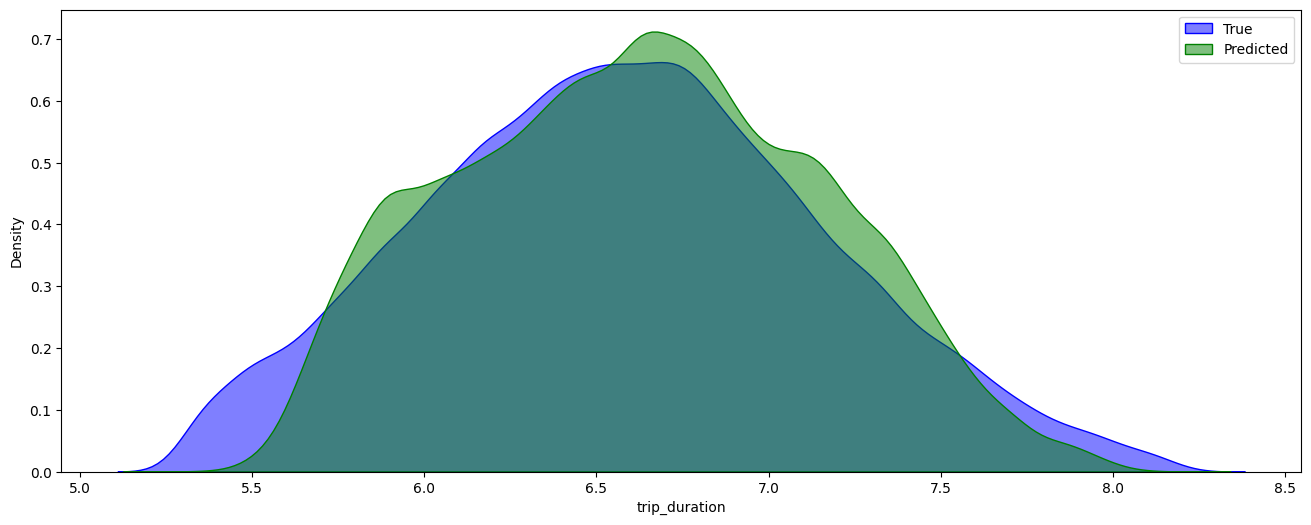

In [15]:
plt.figure(figsize=(16, 6))

# KDE plot for residuals
sns.kdeplot(y_val, color='blue', fill=True, alpha=0.5, label='True')
sns.kdeplot(y_pred, color='green', fill=True, alpha=0.5, label='Predicted')
plt.legend()